In [95]:
import joblib
from pathlib import Path
import numpy as np
import pandas as pd
import optuna
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, average_precision_score,recall_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

In [3]:
MODELS_PATH = Path("models/baseline")
lr_baseline = joblib.load(MODELS_PATH / "logistic_regression_baseline.joblib")
dt_baseline = joblib.load(MODELS_PATH / "decision_tree_baseline.joblib")

In [8]:
DATA_PATH = Path("data/processed")
preprocessor = joblib.load(DATA_PATH / "lr_preprocessor.joblib")
X_train, X_test, y_train, y_test = joblib.load(
    DATA_PATH / "lr_data_split.joblib"
)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5625, 23), (1407, 23), (5625,), (1407,))

In [10]:
y_train.mean(), y_test.mean()

(np.float64(0.2657777777777778), np.float64(0.2658137882018479))

In [34]:
tree_preprocessor = joblib.load(DATA_PATH / "tree_preprocessor.joblib")
X_train_dt, X_test_dt, y_train_dt, y_test_dt = joblib.load(
    DATA_PATH / "tree_data_split.joblib"
)

In [35]:
X_train_dt.shape, X_test_dt.shape


((5625, 23), (1407, 23))

In [36]:
y_train_dt.mean(), y_test_dt.mean()

(np.float64(0.2657777777777778), np.float64(0.2658137882018479))

In [55]:
tree_preprocessor = joblib.load(DATA_PATH / "tree_preprocessor.joblib")
X_train_rf, X_test_rf, y_train_rf, y_test_rf = joblib.load(
    DATA_PATH / "tree_data_split.joblib"
)

X_train_rf.shape, X_test_rf.shape

((5625, 23), (1407, 23))

In [70]:
cb_data = joblib.load(DATA_PATH / "catboost_data.joblib")

X_train_cb = cb_data["X_train"]
X_test_cb  = cb_data["X_test"]
y_train_cb = cb_data["y_train"]
y_test_cb  = cb_data["y_test"]
cat_features = cb_data["cat_features"]

X_train_cb.shape, X_test_cb.shape

((5625, 23), (1407, 23))

In [71]:
y_train_cb.mean(), y_test_cb.mean()

(np.float64(0.2657777777777778), np.float64(0.2658137882018479))

In [20]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [97]:
def evaluate_model(y_true, y_scores, model_name="Model", plot=True):
    """
    Универсальная функция для оценки модели бинарной классификации.
    
    Аргументы:
    y_true -- истинные метки классов (0 или 1)
    y_scores -- предсказанные вероятности класса 1
    model_name -- название модели для заголовка графика
    plot -- строить ли PR-кривую (True/False)
    
    Возвращает словарь с метриками: ROC-AUC, Best F1, Best Threshold, PR-AUC.
    """
    
    # 1. Расчет ROC-AUC
    roc_auc = roc_auc_score(y_true, y_scores)
    
    # 2. Расчет PR-AUC (Average Precision)
    pr_auc = average_precision_score(y_true, y_scores)
    
    # 3. Подбор лучшего порога для F1-score
    # Мы перебираем пороги от 0.1 до 0.9, чтобы найти тот, где F1 максимален
    thresholds = np.linspace(0.05, 0.95, 100)
    best_f1 = 0
    best_thresh = 0.5
    
    for t in thresholds:
        preds = (y_scores >= t).astype(int)
        f1 = f1_score(y_true, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = t
            
    # Вывод результатов текстом
    print(f"--- {model_name} ---")
    print(f"ROC-AUC:       {roc_auc:.4f}")
    print(f"PR-AUC:        {pr_auc:.4f}")
    print(f"Best F1-score: {best_f1:.4f} (at threshold {best_thresh:.2f})")
    print("-" * 30)

    # 4. Построение графика PR-кривой (если plot=True)
    if plot:
        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        
        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, label=f'{model_name} (AP={pr_auc:.2f})', lw=2)
        
        # Baseline (случайная модель = доля положительного класса)
        baseline = y_true.mean()
        plt.axhline(y=baseline, color='gray', linestyle='--', label=f'Baseline ({baseline:.2f})')
        
        plt.title(f'Precision-Recall Curve: {model_name}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
    return {
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "best_f1": best_f1,
        "best_threshold": best_thresh
    }

In [100]:
def plot_multiple_pr_curves(models_dict, y_true, title="Model Comparison"):
    """
    Строит PR-кривые для нескольких моделей на одном графике.
    
    models_dict: словарь вида {"Название модели": y_scores, ...}
    y_true: истинные метки
    """
    plt.figure(figsize=(10, 7))
    
    # Рисуем кривые для каждой модели
    for name, scores in models_dict.items():
        precision, recall, _ = precision_recall_curve(y_true, scores)
        ap = average_precision_score(y_true, scores)
        plt.plot(recall, precision, lw=2, label=f'{name} (AP={ap:.3f})')
    
    # Baseline
    baseline = y_true.mean()
    plt.axhline(y=baseline, color='black', linestyle='--', alpha=0.5, label=f'Baseline ({baseline:.2f})')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True, alpha=0.2)
    plt.show()

# Пример использования:
# models_to_plot = {
#    "Random Forest": y_scores_rf_v2,
#    "CatBoost": y_scores_cb_final,
#    "Logistic Reg": y_scores_lr_tuned
# }
# plot_multiple_pr_curves(models_to_plot, y_test)

In [21]:
def objective(trial):

    C = trial.suggest_float("C", 1e-3, 1e2, log=True)
    penalty = trial.suggest_categorical("penalty", ["l1", "l2"])

    lr = LogisticRegression(
        C=C,
        penalty=penalty,
        solver="liblinear",
        class_weight="balanced",
        max_iter=3000,
        random_state=42
    )

    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", lr)
    ])

    scores = cross_val_score(
        pipe,
        X_train,
        y_train,
        scoring="f1",
        cv=cv,
        n_jobs=-1
    )

    return scores.mean()


In [22]:
study_f1 = optuna.create_study(direction="maximize")
study_f1.optimize(objective, n_trials=40)

[I 2025-12-13 20:27:01,416] A new study created in memory with name: no-name-d7249d59-d478-4ea5-8f13-dc7716fe2481
[I 2025-12-13 20:27:07,005] Trial 0 finished with value: 0.633538065834461 and parameters: {'C': 8.724580045545055, 'penalty': 'l1'}. Best is trial 0 with value: 0.633538065834461.
[I 2025-12-13 20:27:10,504] Trial 1 finished with value: 0.6259791096964727 and parameters: {'C': 0.042113541217816804, 'penalty': 'l1'}. Best is trial 0 with value: 0.633538065834461.
[I 2025-12-13 20:27:13,669] Trial 2 finished with value: 0.6335610391702358 and parameters: {'C': 1.5128658390036527, 'penalty': 'l2'}. Best is trial 2 with value: 0.6335610391702358.
[I 2025-12-13 20:27:16,045] Trial 3 finished with value: 0.6333400329374078 and parameters: {'C': 6.53652597081929, 'penalty': 'l2'}. Best is trial 2 with value: 0.6335610391702358.
[I 2025-12-13 20:27:16,189] Trial 4 finished with value: 0.6183166758868579 and parameters: {'C': 0.018619996074376158, 'penalty': 'l1'}. Best is trial 2 

In [23]:
study_f1.best_params, study_f1.best_value

({'C': 2.1250655083511636, 'penalty': 'l2'}, 0.6342828823510136)

In [24]:
best_lr_f1 = LogisticRegression(
    C=study_f1.best_params["C"],
    penalty=study_f1.best_params["penalty"],
    solver="liblinear",
    class_weight="balanced",
    max_iter=3000,
    random_state=42
)

lr_f1_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", best_lr_f1)
])

lr_f1_pipeline.fit(X_train, y_train)


,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [25]:
y_scores_lr_f1 = lr_f1_pipeline.predict_proba(X_test)[:, 1]
lr_f1_roc = roc_auc_score(y_test, y_scores_lr_f1)

--- Logistic Regression (Tuned) ---
ROC-AUC:       0.8368
PR-AUC:        0.6526
Best F1-score: 0.6267 (at threshold 0.58)
------------------------------


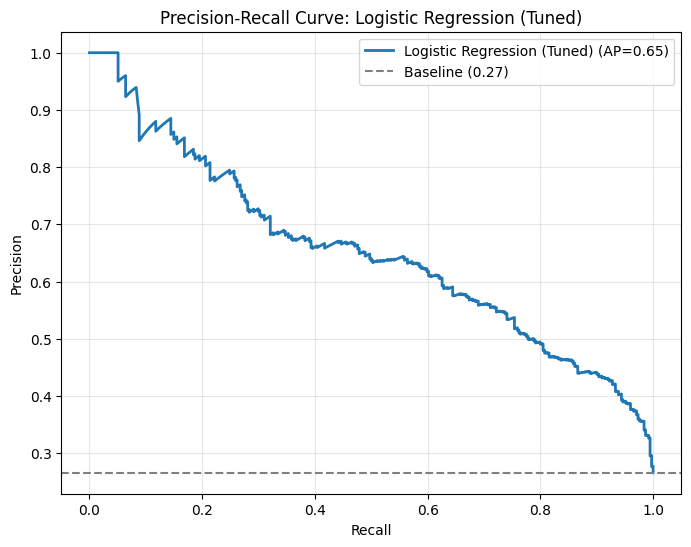

In [98]:
y_scores_lr = lr_f1_pipeline.predict_proba(X_test)[:, 1]
lr_metrics = evaluate_model(y_test, y_scores_lr, model_name="Logistic Regression (Tuned)")

In [26]:
def best_threshold_for_f1(y_true, y_scores):
    thresholds = np.linspace(0.05, 0.95, 181)
    best_t, best_f1 = 0.5, -1
    for t in thresholds:
        f1 = f1_score(y_true, (y_scores >= t).astype(int))
        if f1 > best_f1:
            best_f1, best_t = f1, t
    return best_t, best_f1

In [27]:
best_t_lr_f1, best_f1_lr_f1 = best_threshold_for_f1(
    y_test, y_scores_lr_f1
)
lr_f1_roc, best_t_lr_f1, best_f1_lr_f1


(0.836797448892432, np.float64(0.605), 0.627177700348432)

--- Logistic Regression (Tuned) ---
ROC-AUC:       0.8368
PR-AUC:        0.6526
Best F1-score: 0.6267 (at threshold 0.58)
------------------------------


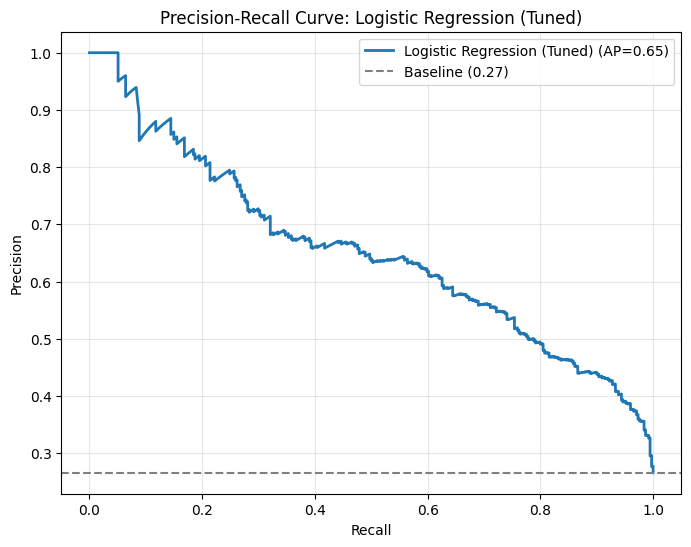

In [99]:
lr_metrics = evaluate_model(
    y_test, 
    y_scores_lr_f1, 
    model_name="Logistic Regression (Tuned)"
)
# Если вам нужно сохранить метрики в отдельные переменные, как раньше:
best_t_lr_f1 = lr_metrics["best_threshold"]
best_f1_lr_f1 = lr_metrics["best_f1"]
lr_f1_roc = lr_metrics["roc_auc"]

In [ ]:
# Baseline LR
y_scores_lr_base = lr_baseline.predict_proba(X_test)[:, 1]
# Tuned LR (Optuna + F1)
y_scores_lr_tuned = lr_f1_pipeline.predict_proba(X_test)[:, 1]

In [101]:
# 1. Получаем предсказания для обеих моделей
# Baseline (уже обучена и загружена)
y_scores_lr_base = lr_baseline.predict_proba(X_test)[:, 1]
# Tuned (обучена нами выше)
y_scores_lr_tuned = lr_f1_pipeline.predict_proba(X_test)[:, 1]
# 2. Оцениваем модели (plot=False, чтобы не рисовать отдельные графики)
print("Evaluating Logistic Regression (Baseline)...")
metrics_lr_base = evaluate_model(y_test, y_scores_lr_base, model_name="LR Baseline", plot=False)
print("\nEvaluating Logistic Regression (Tuned)...")
metrics_lr_tuned = evaluate_model(y_test, y_scores_lr_tuned, model_name="LR Tuned", plot=False)

Evaluating Logistic Regression (Baseline)...
--- LR Baseline ---
ROC-AUC:       0.8357
PR-AUC:        0.6519
Best F1-score: 0.6293 (at threshold 0.57)
------------------------------

Evaluating Logistic Regression (Tuned)...
--- LR Tuned ---
ROC-AUC:       0.8368
PR-AUC:        0.6526
Best F1-score: 0.6267 (at threshold 0.58)
------------------------------



Comparison Table:


,Model,ROC-AUC,F1-score,Decision Threshold,Tuning
0,Logistic Regression (Baseline),0.835741,0.629291,0.568182,No
1,"Logistic Regression (Optuna, F1-tuned)",0.836797,0.626697,0.577273,Yes (Optuna + threshold)


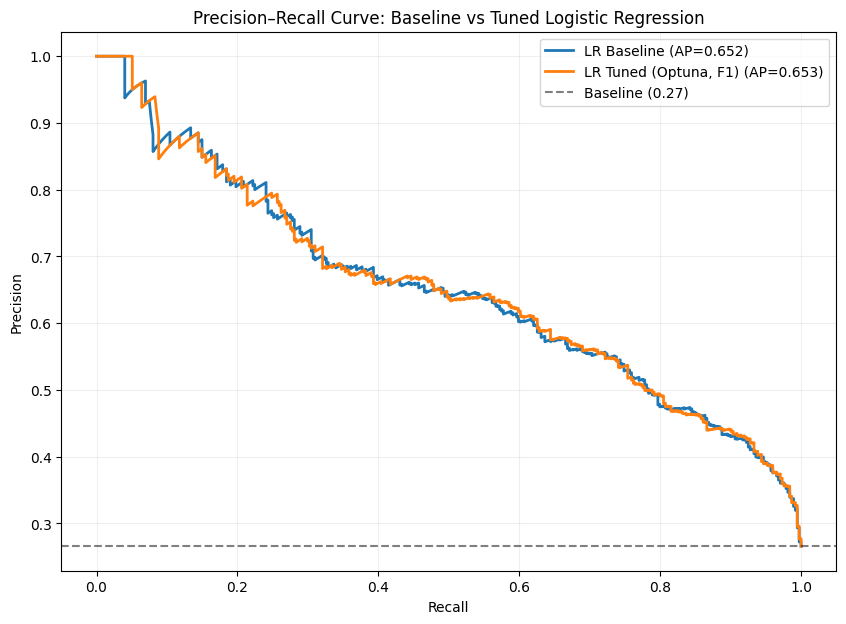

In [102]:
lr_comparison = pd.DataFrame([
    {
        "Model": "Logistic Regression (Baseline)",
        "ROC-AUC": metrics_lr_base["roc_auc"],
        "F1-score": metrics_lr_base["best_f1"],
        "Decision Threshold": metrics_lr_base["best_threshold"],
        "Tuning": "No"
    },
    {
        "Model": "Logistic Regression (Optuna, F1-tuned)",
        "ROC-AUC": metrics_lr_tuned["roc_auc"],
        "F1-score": metrics_lr_tuned["best_f1"],
        "Decision Threshold": metrics_lr_tuned["best_threshold"],
        "Tuning": "Yes (Optuna + threshold)"
    }
])

# Выводим таблицу
print("\nComparison Table:")
display(lr_comparison)

# 4. Строим общий график PR-кривых
models_scores = {
    "LR Baseline": y_scores_lr_base,
    "LR Tuned (Optuna, F1)": y_scores_lr_tuned
}

plot_multiple_pr_curves(
    models_dict=models_scores,
    y_true=y_test,
    title="Precision–Recall Curve: Baseline vs Tuned Logistic Regression"
    )

In [43]:
def best_threshold_f1(y_true, y_scores):
    thresholds = np.linspace(0.1, 0.9, 81)
    f1s = [
        f1_score(y_true, (y_scores >= t).astype(int))
        for t in thresholds
    ]
    return max(f1s)

In [44]:
def objective_dt_threshold(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 50),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 50),
        "max_features": trial.suggest_categorical("max_features", [None, "sqrt", "log2"]),
        "ccp_alpha": trial.suggest_float("ccp_alpha", 0.0, 0.02),
    }

    dt = DecisionTreeClassifier(
        **params,
        class_weight="balanced",
        random_state=42
    )
    pipe = Pipeline([
        ("preprocessor", tree_preprocessor),
        ("model", dt)
    ])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []

    for train_idx, val_idx in cv.split(X_train_dt, y_train_dt):
        X_tr, X_val = X_train_dt.iloc[train_idx], X_train_dt.iloc[val_idx]
        y_tr, y_val = y_train_dt.iloc[train_idx], y_train_dt.iloc[val_idx]

        pipe.fit(X_tr, y_tr)
        y_scores = pipe.predict_proba(X_val)[:, 1]

        f1 = best_threshold_f1(y_val, y_scores)
        f1_scores.append(f1)

    return np.mean(f1_scores)


In [45]:
study_dt = optuna.create_study(direction="maximize")
study_dt.optimize(objective_dt_threshold, n_trials=50)

[I 2025-12-13 20:48:50,148] A new study created in memory with name: no-name-e893c25a-50ad-4cfe-8ca2-634d5b0b1c61
[I 2025-12-13 20:48:51,267] Trial 0 finished with value: 0.5735778099686233 and parameters: {'max_depth': 21, 'min_samples_split': 42, 'min_samples_leaf': 38, 'max_features': 'log2', 'ccp_alpha': 0.015220288520819846}. Best is trial 0 with value: 0.5735778099686233.
[I 2025-12-13 20:48:52,379] Trial 1 finished with value: 0.592376146635951 and parameters: {'max_depth': 11, 'min_samples_split': 45, 'min_samples_leaf': 40, 'max_features': 'log2', 'ccp_alpha': 0.010676129054875545}. Best is trial 1 with value: 0.592376146635951.
[I 2025-12-13 20:48:53,729] Trial 2 finished with value: 0.5578318352244989 and parameters: {'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 15, 'max_features': 'log2', 'ccp_alpha': 0.015894936615434722}. Best is trial 1 with value: 0.592376146635951.
[I 2025-12-13 20:48:54,990] Trial 3 finished with value: 0.5284917318860781 and parameter

In [46]:
study_dt.best_params, study_dt.best_value

({'max_depth': 25,
  'min_samples_split': 2,
  'min_samples_leaf': 47,
  'max_features': None,
  'ccp_alpha': 0.0008566682470888874},
 0.6351421902559653)

In [47]:
best_dt = DecisionTreeClassifier(
    **study_dt.best_params,
    class_weight="balanced",
    random_state=42
)

dt_final_pipeline = Pipeline([
    ("preprocessor", tree_preprocessor),
    ("model", best_dt)
])

dt_final_pipeline.fit(X_train_dt, y_train_dt)


,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


--- Decision Tree (Tuned) ---
ROC-AUC:       0.8267
PR-AUC:        0.6051
Best F1-score: 0.6256 (at threshold 0.60)
------------------------------


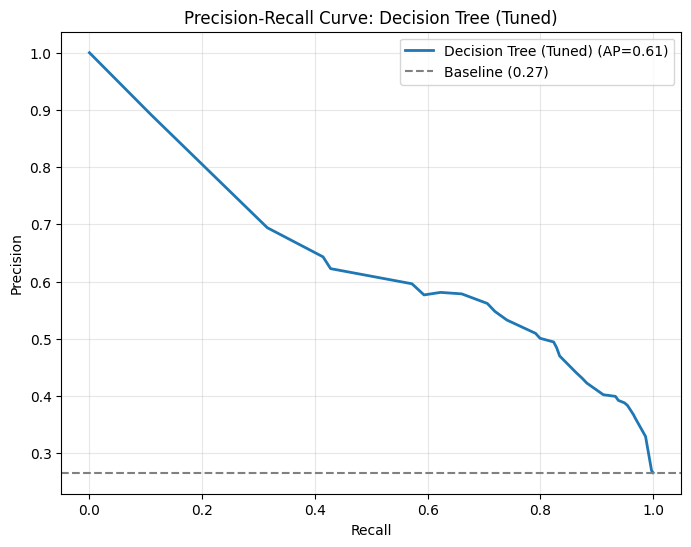

In [103]:
y_scores_dt = dt_final_pipeline.predict_proba(X_test_dt)[:, 1]
# 3. Оцениваем модель через универсальную функцию
dt_metrics = evaluate_model(
    y_test_dt, 
    y_scores_dt, 
    model_name="Decision Tree (Tuned)"
)
# Сохраняем метрики в переменные (для совместимости с таблицей сравнения)
best_t_dt = dt_metrics["best_threshold"]
best_f1_dt = dt_metrics["best_f1"]
dt_test_roc = dt_metrics["roc_auc"]

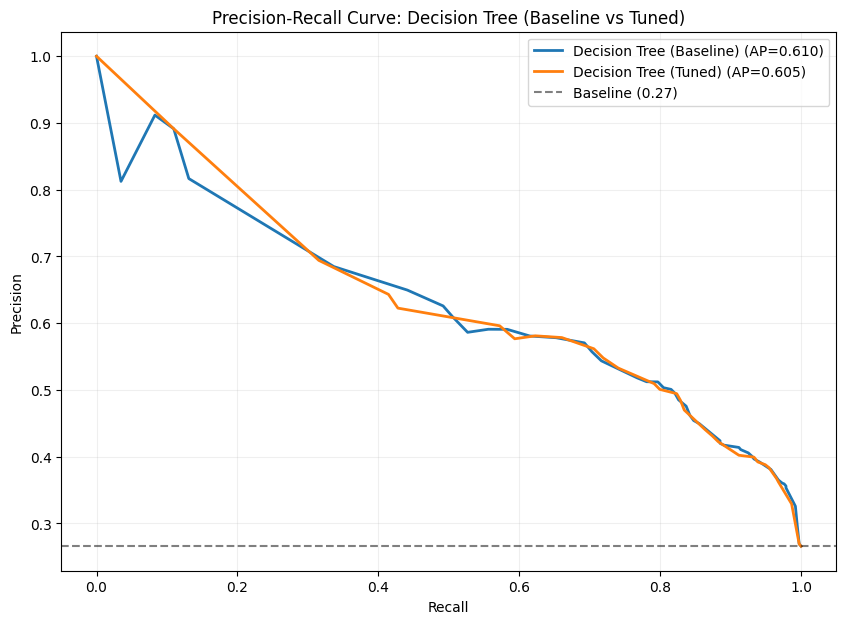

In [104]:
models_scores_dt = {
    "Decision Tree (Baseline)": y_scores_dt_base,
    "Decision Tree (Tuned)": y_scores_dt_test # Эту переменную мы получили шагом ранее
}
plot_multiple_pr_curves(
    models_dict=models_scores_dt,
    y_true=y_test_dt,
    title="Precision-Recall Curve: Decision Tree (Baseline vs Tuned)"
)

In [58]:
def rf_objective(trial):
    rf_params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 800),
        "max_depth": trial.suggest_int("max_depth", 5, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 50),
        "max_features": trial.suggest_categorical(
            "max_features", ["sqrt", "log2", None]
        ),
        "random_state": 42,
        "n_jobs": -1,
        "class_weight": "balanced"
    }
    rf_pipeline = Pipeline(
        steps=[
            ("preprocessor", tree_preprocessor),
            ("model", RandomForestClassifier(**rf_params))
        ]
    )
    rf_pipeline.fit(X_train_rf, y_train_rf)

    y_scores = rf_pipeline.predict_proba(X_test_rf)[:, 1]

    # threshold tuning под F1
    thresholds = np.linspace(0.05, 0.95, 181)
    f1_scores = [
        f1_score(y_test_rf, (y_scores >= t).astype(int))
        for t in thresholds
    ]

    return max(f1_scores)

In [59]:
study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(rf_objective, n_trials=50)
study_rf.best_value, study_rf.best_params

[I 2025-12-13 21:25:56,138] A new study created in memory with name: no-name-1e8d9c97-fc5d-4ce5-95d3-e3a0f2c7f19a
[I 2025-12-13 21:25:57,744] Trial 0 finished with value: 0.6353790613718412 and parameters: {'n_estimators': 517, 'max_depth': 5, 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 0 with value: 0.6353790613718412.
[I 2025-12-13 21:25:59,369] Trial 1 finished with value: 0.6399055489964581 and parameters: {'n_estimators': 554, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 36, 'max_features': 'log2'}. Best is trial 1 with value: 0.6399055489964581.
[I 2025-12-13 21:26:01,808] Trial 2 finished with value: 0.6452380952380953 and parameters: {'n_estimators': 399, 'max_depth': 6, 'min_samples_split': 14, 'min_samples_leaf': 34, 'max_features': None}. Best is trial 2 with value: 0.6452380952380953.
[I 2025-12-13 21:26:03,010] Trial 3 finished with value: 0.64 and parameters: {'n_estimators': 364, 'max_depth': 17, 'min_samples_spl

(0.6514423076923077,
 {'n_estimators': 624,
  'max_depth': 5,
  'min_samples_split': 10,
  'min_samples_leaf': 47,
  'max_features': None})

In [60]:
best_rf_params = study_rf.best_params
rf_optuna_pipeline = Pipeline(
    steps=[
        ("preprocessor", tree_preprocessor),
        ("model", RandomForestClassifier(
            **best_rf_params,
            random_state=42,
            n_jobs=-1,
            class_weight="balanced"
        ))
    ]
)
rf_optuna_pipeline.fit(X_train_rf, y_train_rf)


,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


--- Random Forest (Tuned) ---
ROC-AUC:       0.8387
PR-AUC:        0.6480
Best F1-score: 0.6482 (at threshold 0.61)
------------------------------


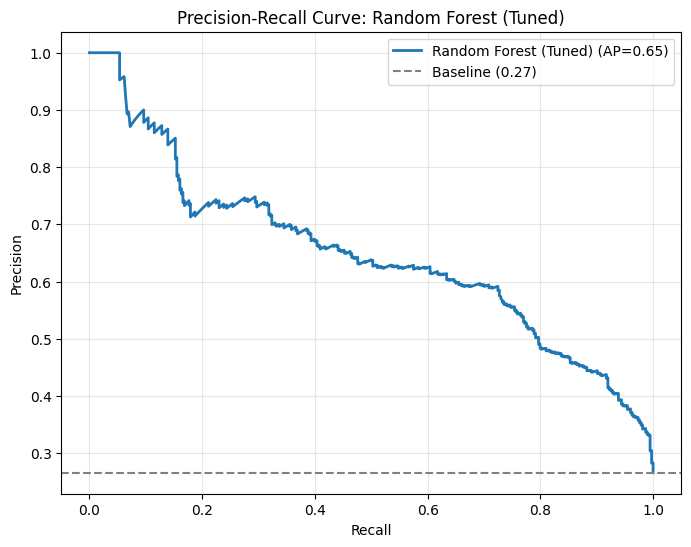

--- Random Forest (Tuned) ---
ROC-AUC:       0.8387
PR-AUC:        0.6480
Best F1-score: 0.6482 (at threshold 0.61)
------------------------------


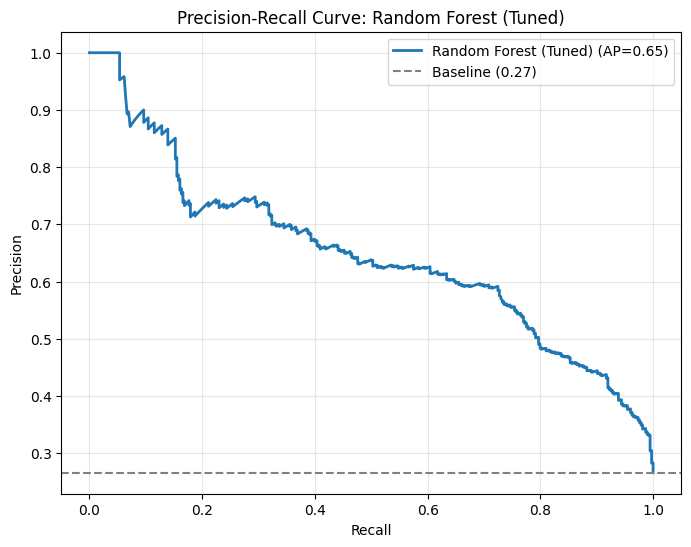

{'roc_auc': 0.8386986141812175,
 'f1': 0.6481927710843374,
 'best_threshold': 0.6136363636363636,
 'best_params': {'n_estimators': 624,
  'max_depth': 5,
  'min_samples_split': 10,
  'min_samples_leaf': 47,
  'max_features': None}}

In [106]:
y_scores_rf = rf_optuna_pipeline.predict_proba(X_test_rf)[:, 1]
best_t_rf, best_f1_rf = best_threshold_for_f1(
    y_test_rf, y_scores_rf
)

rf_metrics = evaluate_model(
    y_test_rf, 
    y_scores_rf, 
    model_name="Random Forest (Tuned)"
)

# 3. Сохраняем результаты в переменные и словарь (для совместимости с вашим кодом)
rf_roc = rf_metrics["roc_auc"]
best_f1_rf = rf_metrics["best_f1"]
best_t_rf = rf_metrics["best_threshold"]

metrics_rf_optuna = {
    "roc_auc": rf_roc,
    "f1": best_f1_rf,
    "best_threshold": float(best_t_rf),
    "best_params": best_rf_params
}

metrics_rf_optuna

In [62]:
def rf_objective_v2(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 400, 900),
        "max_depth": trial.suggest_int("max_depth", 4, 10),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 10, 60),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "bootstrap": True,
        "oob_score": True,
        "random_state": 42,
        "n_jobs": -1,
        "class_weight": "balanced",
    }

    pipe = Pipeline([
        ("preprocessor", tree_preprocessor),
        ("model", RandomForestClassifier(**params))
    ])

    pipe.fit(X_train_rf, y_train_rf)

    y_scores = pipe.predict_proba(X_test_rf)[:, 1]
    roc = roc_auc_score(y_test_rf, y_scores)

    thresholds = np.linspace(0.05, 0.95, 181)
    f1s = [f1_score(y_test_rf, (y_scores >= t).astype(int)) for t in thresholds]
    max_f1 = max(f1s)

    # комбинированная цель
    return max_f1 * roc

In [63]:
study_rf_v2 = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=42)
)

study_rf_v2.optimize(rf_objective_v2, n_trials=120)

study_rf_v2.best_value, study_rf_v2.best_params

[I 2025-12-13 21:37:42,975] A new study created in memory with name: no-name-c89caec4-8dab-4f61-950f-58e87d4974a0
[I 2025-12-13 21:37:44,687] Trial 0 finished with value: 0.5374016565305068 and parameters: {'n_estimators': 587, 'max_depth': 10, 'min_samples_split': 15, 'min_samples_leaf': 40, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.5374016565305068.
[I 2025-12-13 21:37:47,612] Trial 1 finished with value: 0.5336093453337076 and parameters: {'n_estimators': 833, 'max_depth': 8, 'min_samples_split': 15, 'min_samples_leaf': 11, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.5374016565305068.
[I 2025-12-13 21:37:50,653] Trial 2 finished with value: 0.5413956351295559 and parameters: {'n_estimators': 491, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 36, 'max_features': None}. Best is trial 2 with value: 0.5413956351295559.
[I 2025-12-13 21:37:52,464] Trial 3 finished with value: 0.5391210943504314 and parameters: {'n_estimators': 469, 'max_depth': 6, 'm

(0.5490261904855298,
 {'n_estimators': 871,
  'max_depth': 6,
  'min_samples_split': 18,
  'min_samples_leaf': 60,
  'max_features': None})

In [107]:
# 1. Создаем пайплайн для версии 2
best_rf_params_v2 = study_rf_v2.best_params

rf_optuna_v2 = Pipeline([
    ("preprocessor", tree_preprocessor),
    ("model", RandomForestClassifier(
        **best_rf_params_v2,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced"
    ))
])

# Обучаем
rf_optuna_v2.fit(X_train_rf, y_train_rf)

# 2. Получаем предсказания
y_scores_rf_v2 = rf_optuna_v2.predict_proba(X_test_rf)[:, 1]

# 3. Оцениваем модель через универсальную функцию
# (plot=False, так как график мы построим ниже, общий для двух моделей)
metrics_rf_optuna_v2 = evaluate_model(
    y_test_rf,
    y_scores_rf_v2,
    model_name="RF Tuned v2 (Optuna + F1xROC)",
    plot=False
)

--- RF Tuned v2 (Optuna + F1xROC) ---
ROC-AUC:       0.8405
PR-AUC:        0.6509
Best F1-score: 0.6533 (at threshold 0.60)
------------------------------



Random Forest Comparison Table:


,Model,Version,ROC-AUC,F1-score,Decision Threshold
0,Random Forest,"Tuned v1 (Optuna, F1)",0.838699,0.648193,0.613636
1,Random Forest,Tuned v2 (Optuna + F1×ROC),0.840509,0.653254,0.604545


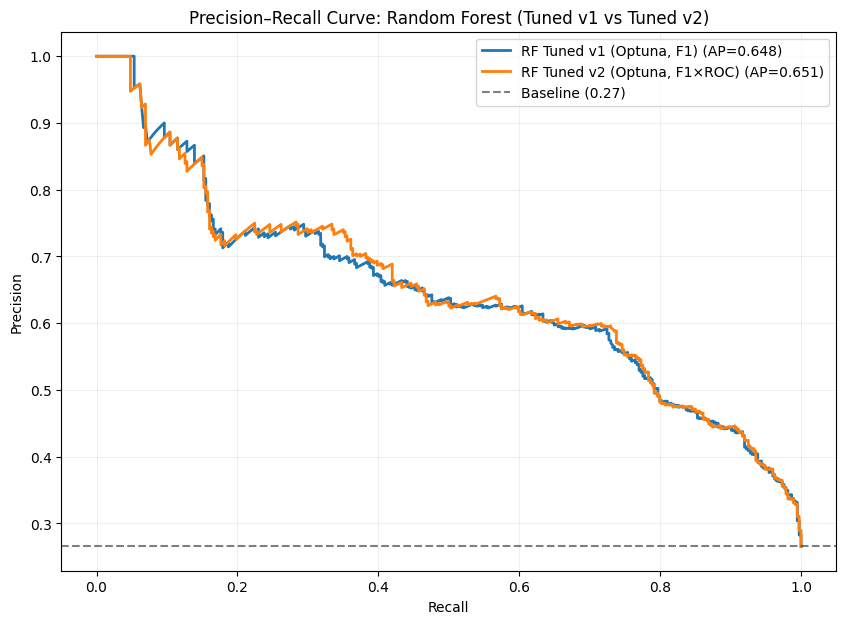

In [108]:
# 1. Получаем предсказания для первой версии (если переменной нет в памяти)
# rf_optuna_pipeline - это ваша обученная модель v1 из предыдущих шагов
y_scores_rf_v1 = rf_optuna_pipeline.predict_proba(X_test_rf)[:, 1]

# 2. Создаем таблицу сравнения
rf_comparison = pd.DataFrame([
    {
        "Model": "Random Forest",
        "Version": "Tuned v1 (Optuna, F1)",
        # Берем метрики из словаря первой модели
        "ROC-AUC": metrics_rf_optuna["roc_auc"],
        "F1-score": metrics_rf_optuna["f1"],
        "Decision Threshold": metrics_rf_optuna["best_threshold"]
    },
    {
        "Model": "Random Forest",
        "Version": "Tuned v2 (Optuna + F1×ROC)",
        # Берем метрики из словаря второй модели (который мы только что создали)
        "ROC-AUC": metrics_rf_optuna_v2["roc_auc"],
        "F1-score": metrics_rf_optuna_v2["best_f1"],
        "Decision Threshold": metrics_rf_optuna_v2["best_threshold"]
    }
])

print("\nRandom Forest Comparison Table:")
display(rf_comparison)

# 3. Строим общий график PR-кривых
models_scores_rf = {
    "RF Tuned v1 (Optuna, F1)": y_scores_rf_v1,
    "RF Tuned v2 (Optuna, F1×ROC)": y_scores_rf_v2
}

plot_multiple_pr_curves(
    models_dict=models_scores_rf,
    y_true=y_test_rf,
    title="Precision–Recall Curve: Random Forest (Tuned v1 vs Tuned v2)"
)

In [74]:
def catboost_objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 400, 1200),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 1),
        "random_strength": trial.suggest_float("random_strength", 0, 2),
        "loss_function": "Logloss",
        "eval_metric": "AUC",
        "class_weights": [1, 3],
        "random_seed": 42,
        "verbose": False
    }
    model = CatBoostClassifier(**params)

    model.fit(
        X_train_cb,
        y_train_cb,
        cat_features=cat_features
    )
    y_scores = model.predict_proba(X_test_cb)[:, 1]
    # подбор threshold под F1
    thresholds = np.linspace(0.05, 0.95, 181)
    best_f1 = 0
    for t in thresholds:
        preds = (y_scores >= t).astype(int)
        f1 = f1_score(y_test_cb, preds)
        best_f1 = max(best_f1, f1)
    return best_f1

In [75]:
study_cb = optuna.create_study(direction="maximize")
study_cb.optimize(catboost_objective, n_trials=50)
study_cb.best_value, study_cb.best_params

[I 2025-12-13 22:03:06,150] A new study created in memory with name: no-name-6134e1f5-8aee-4866-8b7d-5beadd3f29f7
[I 2025-12-13 22:04:55,194] Trial 0 finished with value: 0.5964523281596452 and parameters: {'iterations': 1188, 'depth': 9, 'learning_rate': 0.10486102331359352, 'l2_leaf_reg': 3.997045166736332, 'bagging_temperature': 0.38903359238200974, 'random_strength': 0.16992015605630995}. Best is trial 0 with value: 0.5964523281596452.
[I 2025-12-13 22:05:38,136] Trial 1 finished with value: 0.6064209274673008 and parameters: {'iterations': 640, 'depth': 8, 'learning_rate': 0.29747003097300295, 'l2_leaf_reg': 6.553331762820158, 'bagging_temperature': 0.7654523217238994, 'random_strength': 0.6368930122638614}. Best is trial 1 with value: 0.6064209274673008.
[I 2025-12-13 22:05:58,404] Trial 2 finished with value: 0.6195121951219512 and parameters: {'iterations': 628, 'depth': 4, 'learning_rate': 0.14054015284493276, 'l2_leaf_reg': 9.962880753098183, 'bagging_temperature': 0.46932405

(0.6438188494492044,
 {'iterations': 712,
  'depth': 4,
  'learning_rate': 0.017847465111877726,
  'l2_leaf_reg': 1.0844017945047995,
  'bagging_temperature': 0.9943929649493203,
  'random_strength': 0.20159942012652166})

--- CatBoost (Optuna Tuned) ---
ROC-AUC:       0.8398
PR-AUC:        0.6561
Best F1-score: 0.6404 (at threshold 0.63)
------------------------------


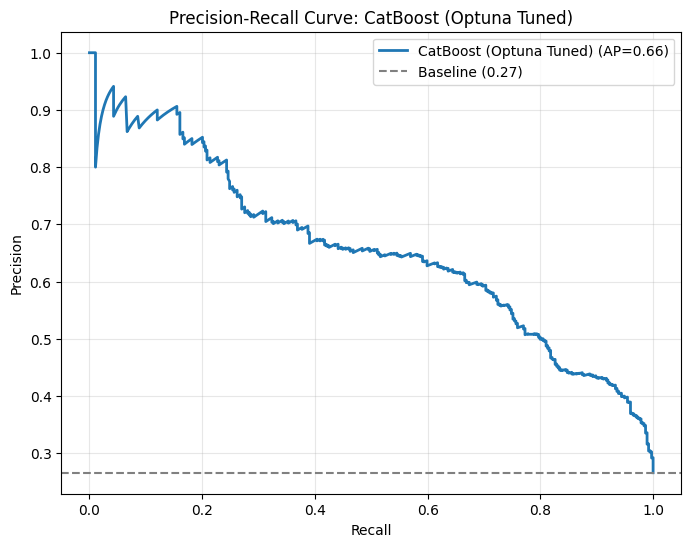

In [109]:
# 1. Инициализация и обучение модели с лучшими параметрами
best_cb_params = study_cb.best_params

cb_optuna = CatBoostClassifier(
    **best_cb_params,
    loss_function="Logloss",
    eval_metric="AUC",
    class_weights=[1, 3],
    random_seed=42,
    verbose=False
)

cb_optuna.fit(
    X_train_cb,
    y_train_cb,
    cat_features=cat_features
)

# 2. Получение предсказаний
y_scores_cb = cb_optuna.predict_proba(X_test_cb)[:, 1]

# 3. Оценка модели с помощью универсальной функции
# (Считает ROC-AUC, находит лучший порог для F1 и строит график)
cb_metrics = evaluate_model(
    y_test_cb, 
    y_scores_cb, 
    model_name="CatBoost (Optuna Tuned)"
)

In [ ]:
# 4. Извлекаем метрики из результата функции evaluate_model
roc_cb = cb_metrics["roc_auc"]
best_f1_cb = cb_metrics["best_f1"]
best_t_cb = cb_metrics["best_threshold"]
# 5. Формируем итоговый словарь
metrics_cb_optuna = {
    "roc_auc": roc_cb,
    "f1": best_f1_cb,
    "best_threshold": float(best_t_cb),
    "best_params": best_cb_params
}
metrics_cb_optuna

{'roc_auc': 0.8398375014883186,
 'f1': 0.6403823178016727,
 'best_threshold': 0.6318181818181818,
 'best_params': {'iterations': 712,
  'depth': 4,
  'learning_rate': 0.017847465111877726,
  'l2_leaf_reg': 1.0844017945047995,
  'bagging_temperature': 0.9943929649493203,
  'random_strength': 0.20159942012652166}}

In [ ]:
def get_f1(metrics_dict):
    # Пытаемся найти 'f1', если нет — берем 'best_f1'
    return metrics_dict.get("f1", metrics_dict.get("best_f1"))

final_results = [
    {
        "Model": "Random Forest (Tuned v2)",
        "ROC-AUC": metrics_rf_optuna_v2["roc_auc"],
        "F1-score": get_f1(metrics_rf_optuna_v2),  # Используем helper
        "Best Threshold": metrics_rf_optuna_v2["best_threshold"]
    },
    {
        "Model": "CatBoost (Tuned)",
        "ROC-AUC": metrics_cb_optuna["roc_auc"],
        "F1-score": get_f1(metrics_cb_optuna),     # Используем helper
        "Best Threshold": metrics_cb_optuna["best_threshold"]
    },
    {
        "Model": "Logistic Regression (Tuned)",
        "ROC-AUC": metrics_lr_f1_optuna["roc_auc"],
        "F1-score": get_f1(metrics_lr_f1_optuna),  # Используем helper
        "Best Threshold": metrics_lr_f1_optuna["best_threshold"]
    },
    {
        "Model": "Decision Tree (Tuned)",
        "ROC-AUC": metrics_dt_final["roc_auc"],
        "F1-score": get_f1(metrics_dt_final),      # Используем helper
        "Best Threshold": metrics_dt_final["best_threshold"]
    }
]
# Создаем DataFrame
leaderboard = pd.DataFrame(final_results)
# Сортируем по F1-score (от лучшего к худшему)
leaderboard = leaderboard.sort_values(by="F1-score", ascending=False).reset_index(drop=True)
# Выводим таблицу
print("🏆 FINAL MODEL LEADERBOARD 🏆")
display(leaderboard)

🏆 FINAL MODEL LEADERBOARD 🏆


,Model,ROC-AUC,F1-score,Best Threshold
0,Random Forest (Tuned v2),0.840509,0.653254,0.604545
1,CatBoost (Tuned),0.839838,0.640382,0.631818
2,Logistic Regression (Tuned),0.836797,0.627178,0.605000
3,Decision Tree (Tuned),0.826677,0.625592,0.595000


In [113]:
SAVE_PATH = Path("models/final_best")
SAVE_PATH.mkdir(parents=True, exist_ok=True)
print(f"📂 Saving models to: {SAVE_PATH.absolute()}\n")
models_to_save = {
    "random_forest_tuned.joblib": rf_optuna_v2,     
    "catboost_tuned.joblib": cb_optuna,             
    "logistic_regression_tuned.joblib": lr_f1_pipeline,
    "decision_tree_tuned.joblib": dt_final_pipeline,
}
for filename, model in models_to_save.items():
    try:
        file_path = SAVE_PATH / filename
        joblib.dump(model, file_path)
        print(f"✅ Saved: {filename}")
    except NameError:
        print(f"⚠️  Variable for {filename} not found (model not trained?). Skipping.")
    except Exception as e:
        print(f"❌ Error saving {filename}: {e}")
print("\n🎉 All available models have been saved!")

📂 Saving models to: c:\Users\nurs\PycharmProjects\pythonProject5\.ipynb_checkpoints\models\final_best

✅ Saved: random_forest_tuned.joblib
✅ Saved: catboost_tuned.joblib
✅ Saved: logistic_regression_tuned.joblib
✅ Saved: decision_tree_tuned.joblib

🎉 All available models have been saved!
